# Anomaly Detection

Anomaly or outlier detection is essentially finding patterns that do not conform to expected behavior. There are several approaches to anomaly detection that are based on either statistical properties, clustering, classification, Principal Component Analysis (PCA), or subsampling. In this notebook we will look at an **autoencoder network** for anomaly or outlier detection. An autoencoder is a neural-net based, unsupervised learning model that is used to learn low-dimensional features that captures some structure underlying the high-dimensional input data.

## Lab Scenario

Groundwater level is an important metric, especially for agriculture states such as Iowa. One of the metrics [U.S. Geological Survey (USGS)](https://www.usgs.gov/) monitors is **depth to water level in feet below the land**. In this lab we will use a synthetic dataset that models certain scenarios for Polk County, Iowa. The three key weather-related metrics we will be using are:

- water-level (depth to water level in feet below the land)
- temperature
- humidity

The data is generated daily using realistic monthly averages for Polk County, Iowa, for the years 2017 – 2019. The data is generated daily for each of the 92 different sensors/locations within Polk County, Iowa – 3 years x 365 days x 92 sensors = 100,740 total sets of data.

We are going to be using 2 copies of the dataset for years 2017 -2019: 

1. Normal conditions for the county.
2. A gradual build up dry conditions in one of the regions in Polk County, Iowa over the months of June and July 2019.

The goal of this notebook is to develop an approach to monitor a group of sensors based on their proximity to each other to predict regional anomalies in real-time. We will be grouping the sensors in 6 different location-based clusters as identified by the previous notebook. Thus, in for model training, we will use cluster_id, along with month, temperature, humidity, and water level as our features.

To train an autoencoder model that learns the structures in the input data in this more complex scenario will need significant compute resources. Thus, in the notebook we will be leveraging the compute resources provided by Azure Machine Learning service for our model training.

## Outline

1. **Setup**: Import required libraries, load the datasets, and create the Azure Machine Learning Workspace.

2. **Remotely Train the Autoencoder Network using the Azure ML Compute**: Create the Azure Machine Learning compute, and submit the training job.

3. **Establish criteria for anomalies**: Define approaches and thresholds for detecting anomalies based on the trained autoencoder model.

4. **Predict anomalies**: Used in the trained autoencoder model, make predictions to identify anomalies.

5. **Principal Component Analysis**: Apply PCA on the encoded dataset and visualize the data representation at lower dimensions.

## Setup

### Import required libraries 

In [3]:
import azureml.core
from azureml.core import Experiment, Workspace, Run, Datastore
from azureml.core.compute import ComputeTarget
from azureml.core.model import Model
from azureml.train.dnn import TensorFlow
from azureml.widgets import RunDetails

print("Azure ML SDK version:", azureml.core.VERSION)

import pandas as pd
import numpy as np
import urllib.request
import os
import math
import timeit
from IPython.display import display, HTML, Image, SVG
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
print("pandas version: {} numpy version: {}".format(pd.__version__, np.__version__))

import sklearn
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn_pandas import DataFrameMapper
from sklearn.cluster import KMeans

import keras
import tensorflow
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

from numpy.random import seed
from tensorflow import set_random_seed

print("keras version: {} tensorflow version: {} sklearn version: {}".format(keras.__version__, 
                                                                        tensorflow.__version__, sklearn.__version__))

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

print('importing libraries done!')

Azure ML SDK version: 1.0.57
pandas version: 0.25.1 numpy version: 1.16.4


Using TensorFlow backend.


keras version: 2.2.5 tensorflow version: 1.14.0 sklearn version: 0.21.3
importing libraries done!


**Helper method to display a pandas dataframe**

In [4]:
def display_dataframe(df_in):
    s = df_in.style.set_properties(**{'text-align': 'left'})
    s.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    display(HTML(s.render()))

### Load the Datasets

In [5]:
normal_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
              'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/anomaly_detection/normal_multi.xlsx')

gradual_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
               'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/anomaly_detection/gradual_multi.xlsx')

normal_df = pd.read_excel(normal_url)
gradual_df = pd.read_excel(gradual_url)

print('Size of dataset: {} rows'.format(len(normal_df)))
print('Done loading datasets!')

Size of dataset: 100740 rows
Done loading datasets!


### Azure Machine Learning service setup
To begin, you will need to provide the following information about your Azure Subscription.

**If you are using your own Azure subscription, please provide names for subscription_id, resource_group, workspace_name and workspace_region to use.** Note that the workspace needs to be of type [Machine Learning Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/setup-create-workspace).

**If an environment is provided to you be sure to replace XXXXX in the values below with your unique identifier.**

In the following cell, be sure to set the values for `subscription_id`, `resource_group`, `workspace_name` and `workspace_region` as directed by the comments (*these values can be acquired from the Azure Portal*).

To get these values, do the following:
1. Navigate to the Azure Portal and login with the credentials provided.
2. From the left hand menu, under Favorites, select `Resource Groups`.
3. In the list, select the resource group with the name similar to `XXXXX`.
4. From the Overview tab, capture the desired values.

Execute the following cell by selecting the `>|Run` button in the command bar above.

In [ ]:
#Provide the Subscription ID of your existing Azure subscription
subscription_id = "" # <- needs to be the subscription with the Quick-Starts resource group

#Provide values for the existing Resource Group 
resource_group = "Quick-Starts-XXXXX" # <- replace XXXXX with your unique identifier

#Provide the Workspace Name and Azure Region of the Azure Machine Learning Workspace
workspace_name = "quick-starts-ws-XXXXX" # <- replace XXXXX with your unique identifier
workspace_region = "eastus" # <- region of your Quick-Starts resource group

In [3]:
#Provide the Subscription ID of your existing Azure subscription
subscription_id = "fdbba0bc-f686-4b8b-8b29-394e0d9ae697"

#Provide values for the existing Resource Group 
resource_group = "Quick-Starts-Labs"

#Provide the Workspace Name and Azure Region of the Azure Machine Learning Workspace
workspace_name = "quick-starts"
workspace_region = "eastus"

### Create and connect to an Azure Machine Learning Workspace

Run the following cell to create a new Azure Machine Learning **Workspace** and save the configuration to disk (next to the Jupyter notebook). 

**Important Note**: You will be prompted to login in the text that is output below the cell. Be sure to navigate to the URL displayed and enter the code that is provided. Once you have entered the code, return to this notebook and wait for the output to read `Workspace configuration succeeded`.

In [6]:
ws = Workspace.create(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group, 
    location = workspace_region,
    exist_ok = True)

ws.write_config()
print('Workspace configuration succeeded')

Workspace configuration succeeded


## Remotely Train the Autoencoder Network using the Azure ML Compute

In the following cells, you will *not* train the model against the data you just downloaded using the resources provided by Azure Notebooks. Instead, you will deploy an Azure ML Compute cluster that will download the data and use a trainings script to train the model. All of the training will be performed remotely with respect to this notebook. 

### Create AML Compute Cluster

Azure Machine Learning Compute is a service for provisioning and managing clusters of Azure virtual machines for running machine learning workloads. Let's create a new Aml Compute in the current workspace, if it doesn't already exist. We will run the model training jobs on this compute target. This will take couple of minutes to create.

In [8]:
### Create AML CPU based Compute Cluster
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "amlcompute-ad"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6',
                                                           min_nodes=1, max_nodes=1)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# Use the 'status' property to get a detailed status for the current AmlCompute. 
print(compute_target.status.serialize())

Creating a new compute target...
Creating
Succeeded...........
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 1, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-09-14T18:19:52.599000+00:00', 'errors': None, 'creationTime': '2019-09-14T18:18:32.961871+00:00', 'modifiedTime': '2019-09-14T18:18:49.358655+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 1, 'maxNodeCount': 1, 'nodeIdleTimeBeforeScaleDown': ''}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


### Create the training script

In [9]:
script_file_folder = './scripts'
script_file_name = 'train.py'
script_file_full_path = os.path.join(script_file_folder, script_file_name)
os.makedirs(script_file_folder, exist_ok=True)

In [36]:
%%writefile $script_file_full_path
import os
import math
import timeit
import numpy as np
import pandas as pd
np.random.seed(437)

print("pandas version: {} numpy version: {}".format(pd.__version__, np.__version__))

import sklearn
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn_pandas import DataFrameMapper

import keras
import tensorflow
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
from numpy.random import seed
from tensorflow import set_random_seed

print("keras version: {} tensorflow version: {} sklearn version: {}".format(keras.__version__, 
                                                                            tensorflow.__version__, 
                                                                            sklearn.__version__))

print("Loading data file.")
normal_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
              'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/anomaly_detection/normal_multi.xlsx')

normal_df = pd.read_excel(normal_url)
print("Loading data file completed.")

feature_cols = ['cluster_id', 'month', 'temperature', 'humidity', 'water_level']
categorical = ['cluster_id', 'month']
#feature_cols = ['device_id', 'cluster_id', 'month', 'temperature', 'humidity', 'water_level']
#categorical = ['device_id', 'cluster_id', 'month']
numerical = ['temperature', 'humidity', 'water_level']

numeric_transformations = [([f], Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])) for f in numerical]
    
categorical_transformations = [([f], OneHotEncoder(handle_unknown='ignore', sparse=False)) for f in categorical]

transformations = categorical_transformations + numeric_transformations

clf = Pipeline(steps=[('preprocessor', DataFrameMapper(transformations))])

X = clf.fit_transform(normal_df[feature_cols])
X_train = X
np.random.shuffle(X_train)

seed(10)
set_random_seed(50)
act_func = 'elu'

input_ = Input(shape=(X_train.shape[1],))
x = Dense(100, activation=act_func)(input_)
x = Dense(50, activation=act_func)(x)
x = Dense(25, activation=act_func)(x)
encoder = Dense(12, activation=act_func, name='feature_vector')(x)
x = Dense(25, activation=act_func)(encoder)
x = Dense(50, activation=act_func)(x)
x = Dense(100, activation=act_func)(x)
output_ = Dense(X_train.shape[1], activation=act_func)(x)

model = Model(input_, output_)
lr = 0.001
opt = keras.optimizers.Adam(lr=lr)
model.compile(loss='mse', optimizer=opt)

encoder_model = Model(inputs=model.input, outputs=model.get_layer('feature_vector').output)
encoder_model.compile(loss='mse', optimizer='adam')

epochs = 200
batch_size = 16

print('')
print(model.summary())
print('')
print('lr: ', lr)
print('epochs: ', epochs)
print('batch_size: ', batch_size)
print('')

def schedule(epoch_number, current_lr):
    lr = current_lr
    if (epoch_number < 25):
        lr = 0.001
    if (epoch_number >= 25) & (epoch_number < 35):
        lr = 0.0005
    if (epoch_number >= 35) & (epoch_number < 50):
        lr = 0.0003
    if (epoch_number >= 50) & (epoch_number < 60):
        lr = 0.0001
    if (epoch_number >= 60) & (epoch_number < 70):
        lr = 0.00008
    if (epoch_number >= 70) & (epoch_number < 80):
        lr = 0.00006
    if (epoch_number >= 80) & (epoch_number < 90):
        lr = 0.00004
    if (epoch_number >= 90) & (epoch_number < 100):
        lr = 0.00002
    if (epoch_number >= 100) & (epoch_number < 125):
        lr = 0.000009
    if (epoch_number >= 125) & (epoch_number < 150):
        lr = 0.000007
    if (epoch_number >= 150) & (epoch_number < 175):
        lr = 0.000005
    if (epoch_number >= 175) & (epoch_number < 200):
        lr = 0.000001
    return lr

lr_sch = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

print("Model training starting...")
start_time = timeit.default_timer()
history = model.fit(X_train, X_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split=0.2, 
                    callbacks=[lr_sch], 
                    verbose=2)
elapsed_time = timeit.default_timer() - start_time
print("Model training completed.")
print('Elapsed time (min): ', round(elapsed_time/60.0,0))

os.makedirs('./output/models', exist_ok=True)
model.save(os.path.join('./output/models', 'anomaly_detection_multi_full_model.h5'))
encoder_model.save(os.path.join('./output/models', 'anomaly_detection_multi_encoder_model.h5'))

with open(os.path.join('./output/models', 'history.txt'), 'w') as f:
    f.write(str(history.history))
    
print("Models saved in ./output/models folder")
print("Saving model files completed.")

Overwriting ./scripts/train.py


### Create the Keras estimator

In [37]:
keras_est = TensorFlow(source_directory=script_file_folder,
                       compute_target=compute_target,
                       entry_script=script_file_name, 
                       conda_packages=['numpy==1.16.4', 'xlrd==1.2.0', 'pandas==0.25.1', 'scikit-learn==0.21.3'], 
                       pip_packages=['sklearn-pandas==1.8.0', 'keras==2.2.5'], 
                       framework_version='1.13')

### Submit the training run

The code pattern to submit a training run to Azure Machine Learning compute targets is always:

- Create an experiment to run.
- Submit the experiment.
- Wait for the run to complete.

#### Create the experiment

In [ ]:
experiment_name = 'anomaly-detection-lab2'
experiment = Experiment(ws, experiment_name)

#### Submit the experiment

Note that experiment run will perform the following:

- Build and deploy the container to Azure Machine Learning compute (~8 minutes)
- Execute the training script (~22 minutes)

If you change only the training script and re-submit, it will run faster the second time because the necessary container is already prepared so the time requried is just that for executing the training script.

In [38]:
run = experiment.submit(keras_est, tags = {"type": "anomaly-detection"})

#### Monitor the Run

Using the azureml Jupyter widget, you can monitor the training run. This will approximately take around 30 minutes to complete. Once the training is completed you can then download the trained models locally by running the **Download the trained models** cell.

Instead of waiting for 30 minutes, you can continue working on the notebook below by first downloading previously trained models. Go to cell **Load Pretrained Models** and continue.

In [39]:
RunDetails(run).show()

A Jupyter Widget

### Download the trained models

Skip the **Load Pretrained Models** cell to continue using your models.

In [ ]:
# create an output folder in the current directory
os.makedirs('./output/models', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('output/models'):
        output_file_path = os.path.join('./output/models', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

# Load the trained models - Skip the Load Pretrained Models cell to continue using your models
model = load_model('./output/models/anomaly_detection_multi_full_model.h5')
encoder_model = load_model('./output/models/anomaly_detection_multi_encoder_model.h5')
print('Models loaded!')

### Load Pretrained Models

Run this cell if you want to load previously trained models and continue working on this notebook.

In [7]:
os.makedirs('./models', exist_ok=True)

full_model_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
                  'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/'
                  'anomaly_detection/anomaly_detection_multi_full_model.h5')

encoder_model_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
                     'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/'
                     'anomaly_detection/anomaly_detection_multi_encoder_model.h5')

urllib.request.urlretrieve(full_model_url, './models/anomaly_detection_multi_full_model.h5')
urllib.request.urlretrieve(encoder_model_url, './models/anomaly_detection_multi_encoder_model.h5')

# Load the pretrained models
model = load_model('./models/anomaly_detection_multi_full_model.h5')
encoder_model = load_model('./models/anomaly_detection_multi_encoder_model.h5')
print('Models loaded!')

Models loaded!


## Establish Criteria for Anomalies

The autoencoder network is trained using normal data where it first compresses the input data and then reconstructs the input data. During training the network learns the interactions between various input variables under normal conditions and learns to reconstruct the input variables back to their original values. The reconstruction error is the error is reproducing back the original input values. We will be using `Mean Absolute Error` as our measure for the reconstruction error. The basic idea behind anomaly detection is that the reconstruction error using the trained network for anomalous inputs will be higher than what is typically observed with normal data. 

Thus, one of the parameters we need to understand is the **threshold for the reconstruction error** that identifies anomalous input data.

### Setup data preprocessors

The following cell sets-up the data preprocessing pipeline that is identical to the one used during model training.

We are using **cluster_id**, **month**, **temperature**, **humidity**, and **water level** as our features for the network. 

In [6]:
feature_cols = ['cluster_id', 'month', 'temperature', 'humidity', 'water_level']
categorical = ['cluster_id', 'month']
numerical = ['temperature', 'humidity', 'water_level']

numeric_transformations = [([f], Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])) for f in numerical]
    
categorical_transformations = [([f], OneHotEncoder(handle_unknown='ignore', sparse=False)) for f in categorical]

transformations = categorical_transformations + numeric_transformations

clf = Pipeline(steps=[('preprocessor', DataFrameMapper(transformations))])

X = clf.fit_transform(normal_df[feature_cols])

### Make predictions and compute reconstruction errors for the normal dataset

Next, we will make predictions on the normal dataset, compute the reconstruction error for individual set of inputs, and look that the upper and lower bounds for the reconstruction errors.

In [7]:
X_train = clf.transform(normal_df[feature_cols]) # Keep the order
X_pred = model.predict(X_train)
loss_mae = np.mean(np.abs(X_pred-X_train), axis = 1)
normal_df['loss_mae'] = loss_mae
stats = normal_df.loss_mae.describe()
whis = 2.0
upper_bound = (whis* (stats['75%'] - stats['25%']) + stats['75%'])
lower_bound = (-whis* (stats['75%'] - stats['25%']) + stats['25%'])
print(('Mean Absolute Error: lower bound: {}, upper bound: {}').format(lower_bound, upper_bound))

Mean Absolute Error: lower bound: -4.023515359677504e-05, upper bound: 0.00044950010699392574


### Visualize the reconstruction errors for the normal dataset

It appears that the threshold value of `0.001` is a reasonable cutoff to identify anomalous input data.

In [1]:
# Setup upper_bound for anomalous reconstruction error
upper_bound = 0.001

<IPython.core.display.Javascript object>


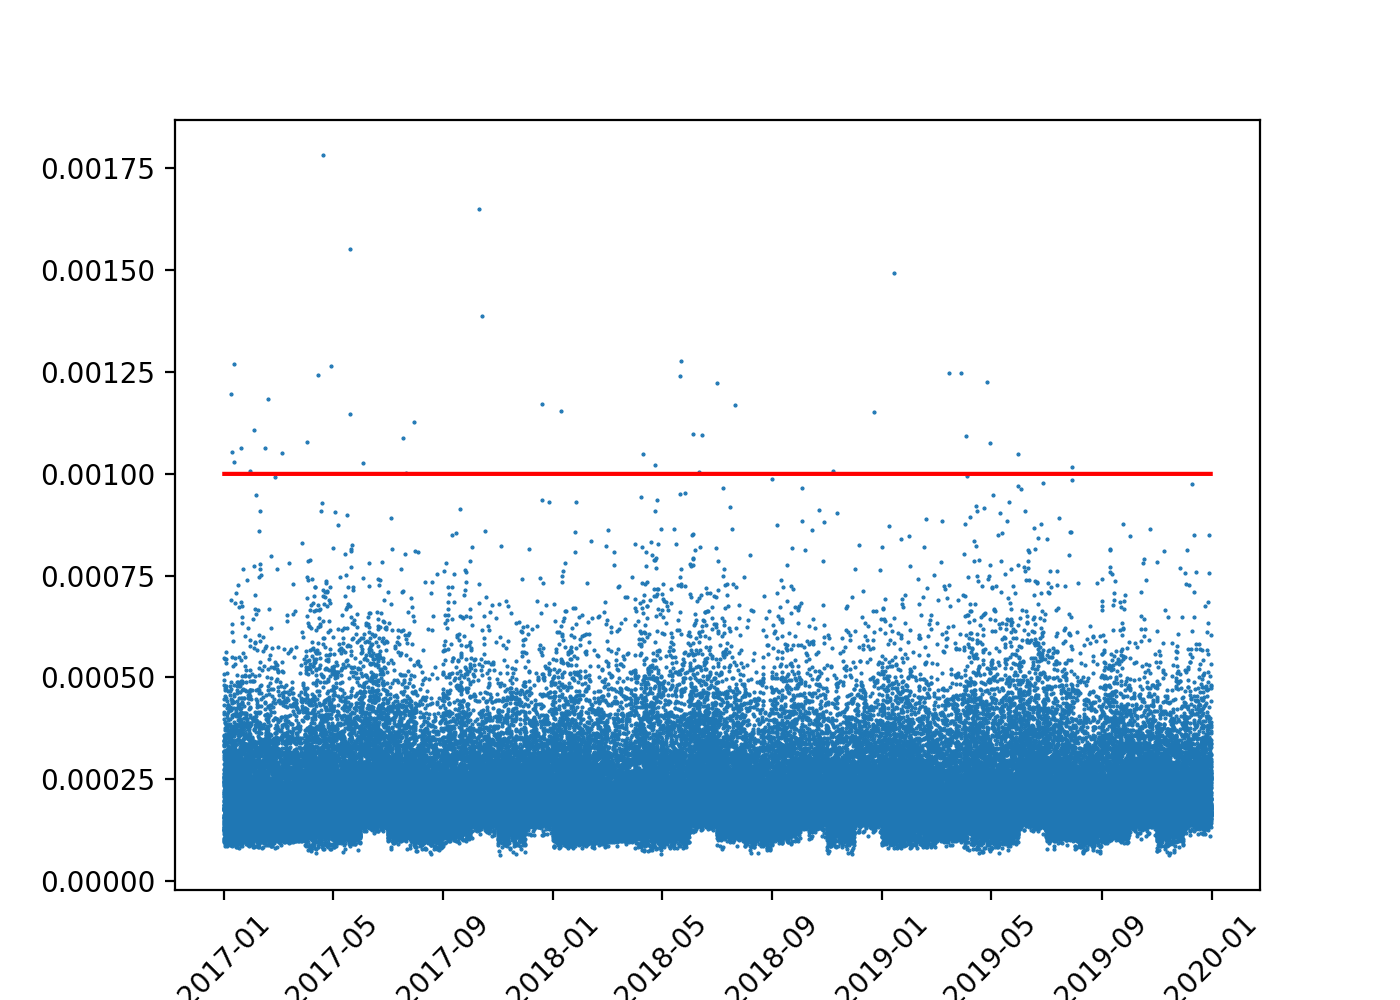

In [9]:
plt.figure(figsize=(7, 5))

upper_boundary = upper_bound * np.ones(len(normal_df.date.unique()))

plt.plot_date(normal_df.date, normal_df.loss_mae, markersize=0.5)
plt.plot(normal_df.date.unique(), upper_boundary, color='r')

plt.xticks(fontsize=10, rotation=45);

plt.show()

### Visualize the reconstruction errors for the gradual datasets

Make predictions on the gradual dataset, compute the reconstruction error for individual set of inputs. You will see a ramp up in the reconstruction error for some set of data points around June-August 2019.

In [10]:
X_gradual = clf.transform(gradual_df[feature_cols])
X_gradual_pred = model.predict(X_gradual)
loss_mae_gradual = np.mean(np.abs(X_gradual-X_gradual_pred), axis = 1)

gradual_df['loss_mae'] = loss_mae_gradual

<IPython.core.display.Javascript object>


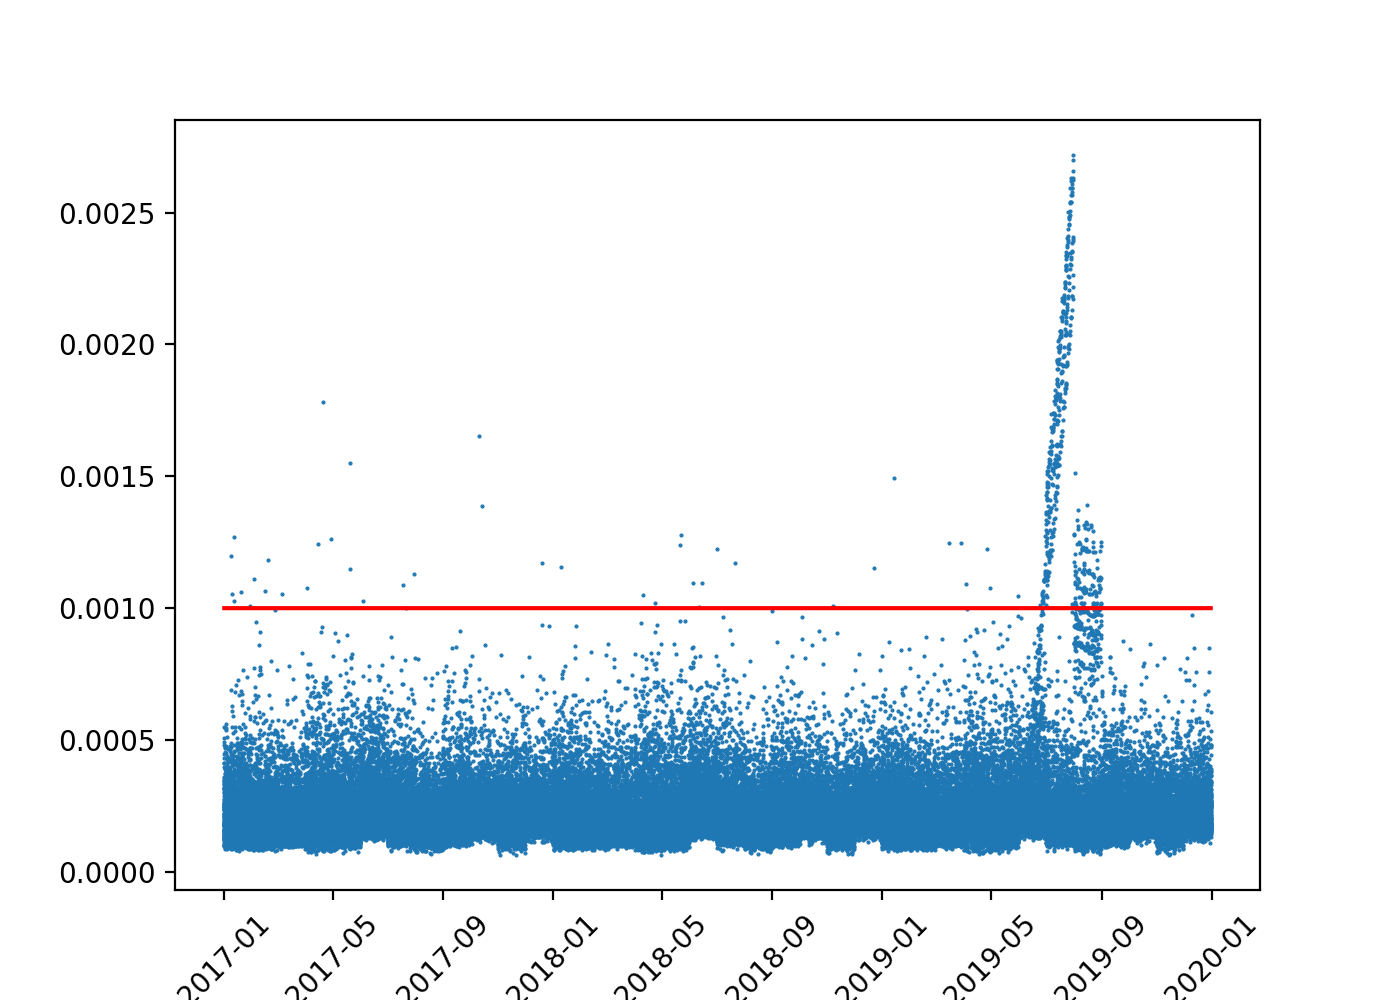

In [11]:
plt.figure(figsize=(7, 5))

upper_boundary = upper_bound * np.ones(len(gradual_df.date.unique()))

plt.plot_date(gradual_df.date, gradual_df.loss_mae, markersize=0.5)
plt.plot(gradual_df.date.unique(), upper_boundary, color='r')

plt.xticks(fontsize=10, rotation=45);

plt.show()

### Visualize the reconstruction errors for the various region clusters in the gradual datasets

**Is there a lower error threshold we can monitor to detect the potential anomaly earlier in the time scale?**

In [12]:
cluster_df = gradual_df.groupby(['date', 'cluster_id'])['water_level', 'loss_mae'].mean()
cluster_df.reset_index(drop=False, inplace=True)

In [13]:
cluster_upper_bound = 0.0005

<IPython.core.display.Javascript object>


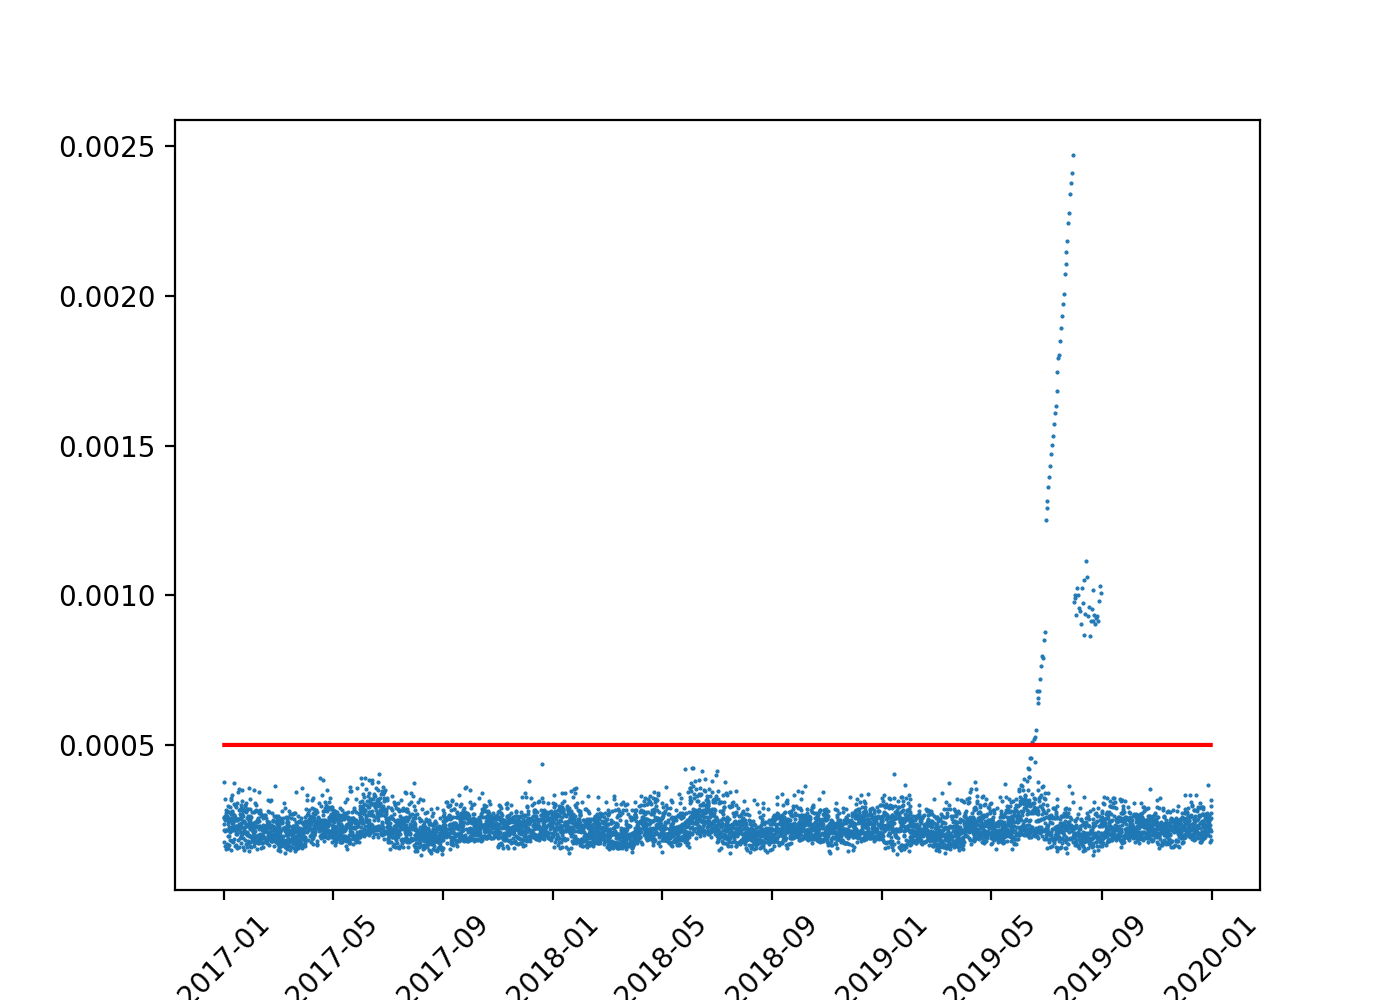

In [14]:
plt.figure(figsize=(7, 5))

cluster_upper_boundary = cluster_upper_bound * np.ones(len(cluster_df.date.unique()))

plt.plot_date(cluster_df.date, cluster_df.loss_mae, markersize=0.5)
plt.plot(cluster_df.date.unique(), cluster_upper_boundary, color='r')

plt.xticks(fontsize=10, rotation=45);

plt.show()

## Predict Anomalies

With the two established thresholds: **0.001** for point anomalies and **0.0005** for cluster anomalies, we will add the two types of predictions to our data sets, standard point anomalies (`anomaly_std`), and anomalies based on cluster averages (`anomaly_cluster`).

In [16]:
def isAnomaly(date, cluster_id):
    loss = cluster_df.loc[lambda x: (x.date == date) & (x.cluster_id == cluster_id)]['loss_mae'].values[0]
    return (True if loss >= cluster_upper_bound else False)

**This cell will take around 3-4 minutes to complete**

In [17]:
start_time = timeit.default_timer()
gradual_df['anomaly_std'] = gradual_df.loss_mae.apply(lambda x: True if x > upper_bound else False)
gradual_df['anomaly_cluster'] = gradual_df.apply(lambda x: isAnomaly(x.date, x.cluster_id), axis = 1)
elapsed_time = timeit.default_timer() - start_time
print('Elapsed time (min): ', round(elapsed_time/60.0,0))

Elapsed time (min):  3.0


**Review Anomalies in the Gradual dataset**

The table shows that regional anomalies are predicted for **cluster 1 / North region**. Furthermore, the `anomaly_cluster` starts on June 14th 2019 almost 16 days before the reconstruction error (`loss_mae`) exceeds the normal threshold.

In [42]:
display_dataframe(gradual_df[(gradual_df.anomaly_cluster == True)])

### Review the reconstruction error for the North region

<IPython.core.display.Javascript object>


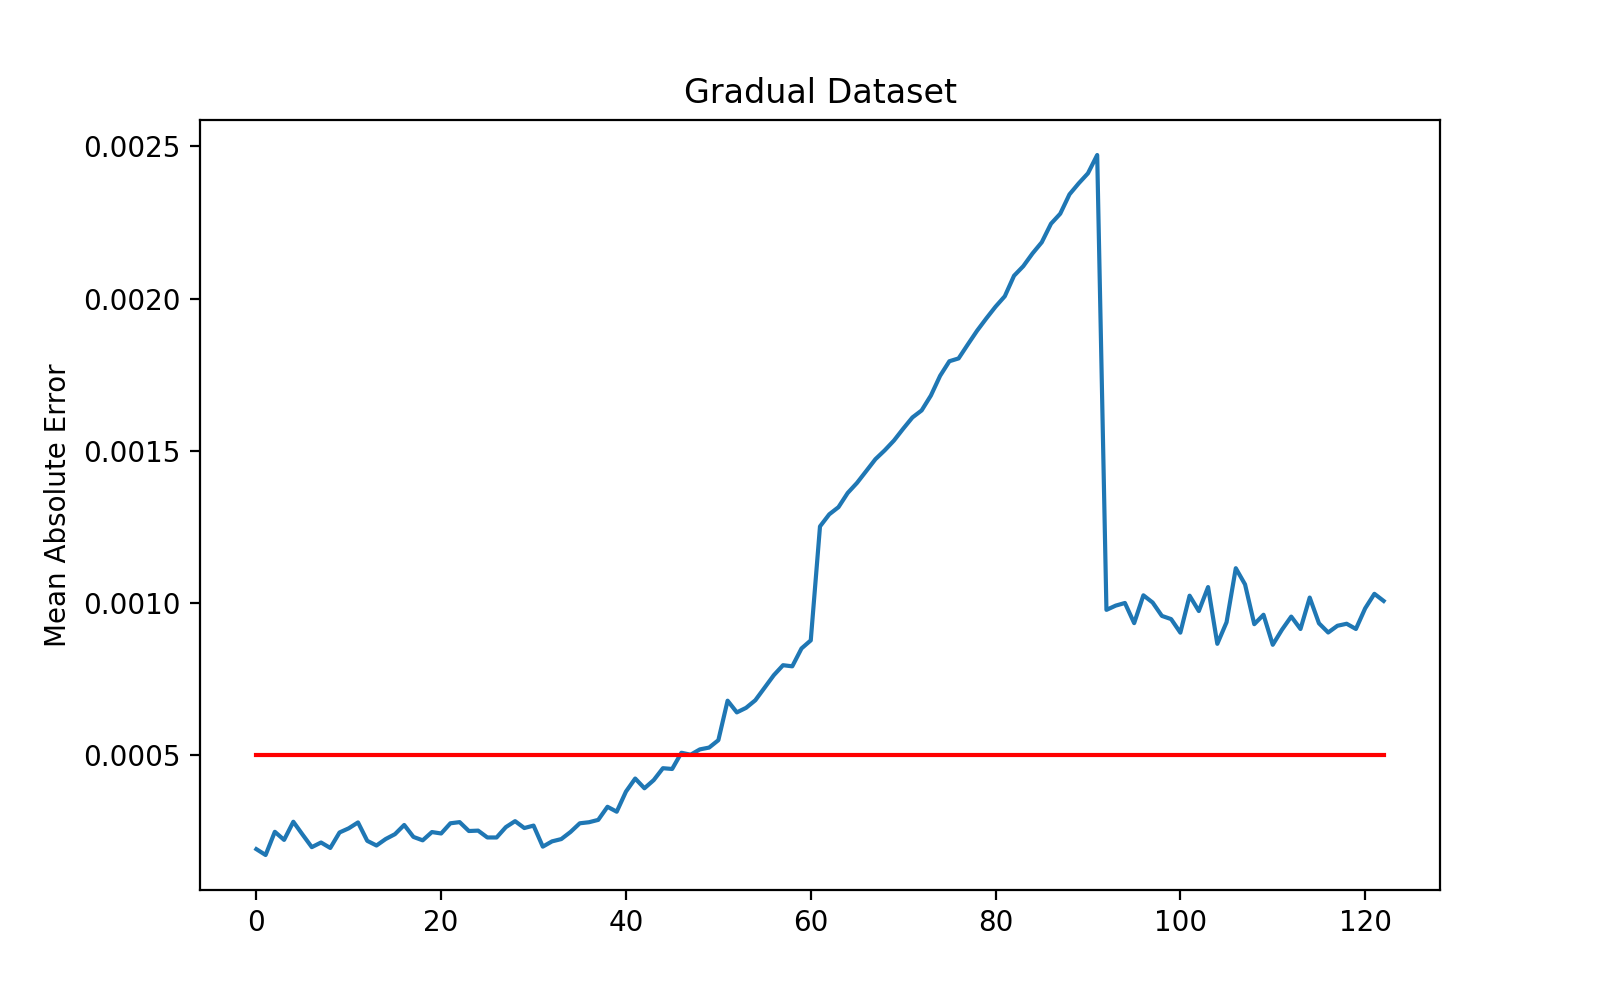

Text(0, 0.5, 'Mean Absolute Error')

In [15]:
f, ax = plt.subplots(figsize=(8, 5))

gradual_test_df = cluster_df.loc[lambda d: (d.date >= '2019-05-01') & (d.date <= '2019-08-31') & 
                                 (d.cluster_id == 1), :]

upper_boundary = cluster_upper_bound * np.ones(len(gradual_test_df))

ax.plot(gradual_test_df.loss_mae.values)
ax.plot(upper_boundary, color='r')

ax.set_title('Gradual Dataset')
ax.set_ylabel('Mean Absolute Error');

### Visualize Anomalies in the Observed Water Levels in the North region

Next, we will visualize the anomalies in the measured water levels during the anomalous period (June-August 2019).

In [18]:
gradual_test_df = gradual_df.loc[lambda d: (d.date.dt.year == 2019) & (d.cluster_id == 1) & 
                                ((d.date.dt.month == 6) | (d.date.dt.month == 7) | (d.date.dt.month == 8)), :]

<IPython.core.display.Javascript object>


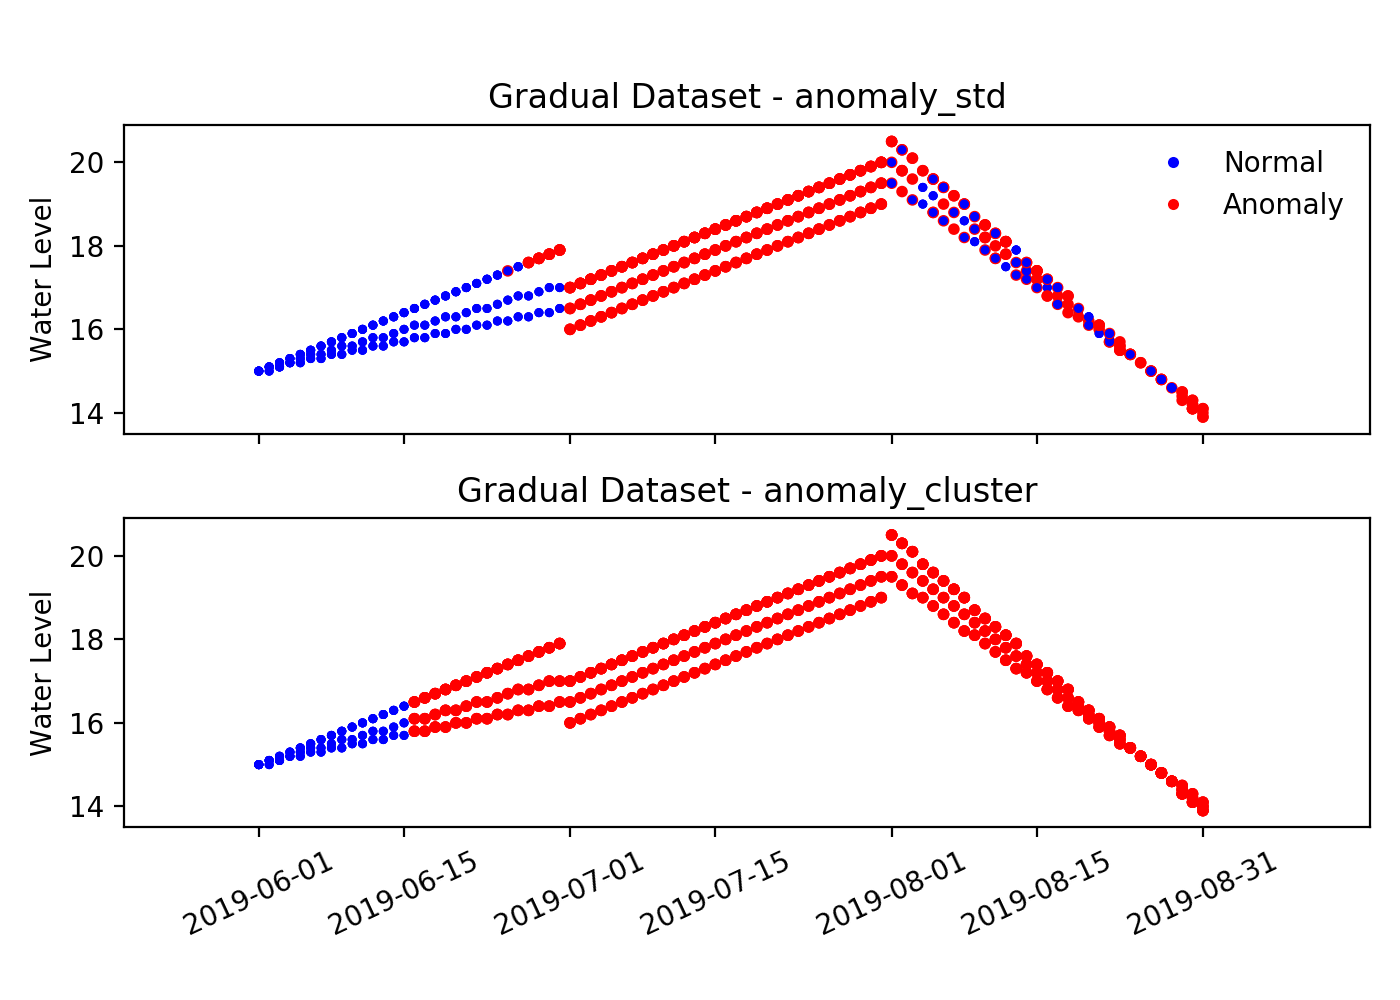

In [19]:
f, ax = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(7, 5))

colors_g_1 = ['red' if value == True else 'blue' for value in gradual_test_df.anomaly_std.values]
size_g_1 = [10 if value == True else 5 for value in gradual_test_df.anomaly_std.values]
colors_g_2 = ['red' if value == True else 'blue' for value in gradual_test_df.anomaly_cluster.values]
size_g_2 = [10 if value == True else 5 for value in gradual_test_df.anomaly_cluster.values]

ax[0].scatter(gradual_test_df.date, gradual_test_df.water_level, s = size_g_1, c = colors_g_1)
ax[1].scatter(gradual_test_df.date, gradual_test_df.water_level, s = size_g_2, c = colors_g_2)

ax[0].set_title('Gradual Dataset - anomaly_std')
ax[1].set_title('Gradual Dataset - anomaly_cluster')

ax[0].set_ylabel('Water Level')
ax[1].set_ylabel('Water Level')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='b', markersize=5), 
                  Line2D([0], [0], marker='o', color='w', label='Anomaly', markerfacecolor='r', markersize=5)]

ax[0].legend(handles=legend_elements, frameon=False)
#ax[1].legend(handles=legend_elements, frameon=False)

ax[1].xaxis.set_ticks(['2019-06-01', '2019-06-15', '2019-07-01', '2019-07-15', 
                       '2019-08-01', '2019-08-15', '2019-08-31'])

plt.xticks(fontsize=10, rotation=25);

f.tight_layout(rect=[0, 0.03, 1, 0.95])

## Principal Component Analysis

Generate the top N principal components of the encoded representation of the input data for the gradual dataset during the anomalous period.

In [20]:
gradual_anomalies = gradual_df.loc[lambda d: (d.date.dt.year == 2019) & (d.cluster_id == 1) & 
                                   ((d.date.dt.month == 5) | (d.date.dt.month == 6) | 
                                    (d.date.dt.month == 7) | (d.date.dt.month == 8)), :]
gradual_anomalies_encoded = encoder_model.predict(clf.transform(gradual_anomalies[feature_cols]))

Generate principal components for **N = [2, 3, 4, 5]**

In [21]:
pca_components = [2, 3, 4, 5]
gradual_anomalies_pca = []

def pca_analysis(input, results, anomaly_type):
    for comp in pca_components: 
        pca = PCA(n_components = comp)
        pca_result = pca.fit_transform(input)
        print('{} - Cumulative explained variation for {} principal components: {}'.format(
            anomaly_type, comp, np.sum(pca.explained_variance_ratio_)))
        results.append(pca_result)

pca_analysis(gradual_anomalies_encoded, gradual_anomalies_pca, 'Gradual anomalies')

Gradual anomalies - Cumulative explained variation for 2 principal components: 0.9074233770370483
Gradual anomalies - Cumulative explained variation for 3 principal components: 0.9982160329818726
Gradual anomalies - Cumulative explained variation for 4 principal components: 0.9996492862701416
Gradual anomalies - Cumulative explained variation for 5 principal components: 0.999887228012085


### Visualize the Principal Components for N = 3

Visualize the top 3 principal components of the encoded representation of the input data.

Looking at the 3-D plots, it appears that the first principal component is largely sufficient to predict anomalies. The anomalous or near-anomalous data lies in the region **x < 0**.

<IPython.core.display.Javascript object>


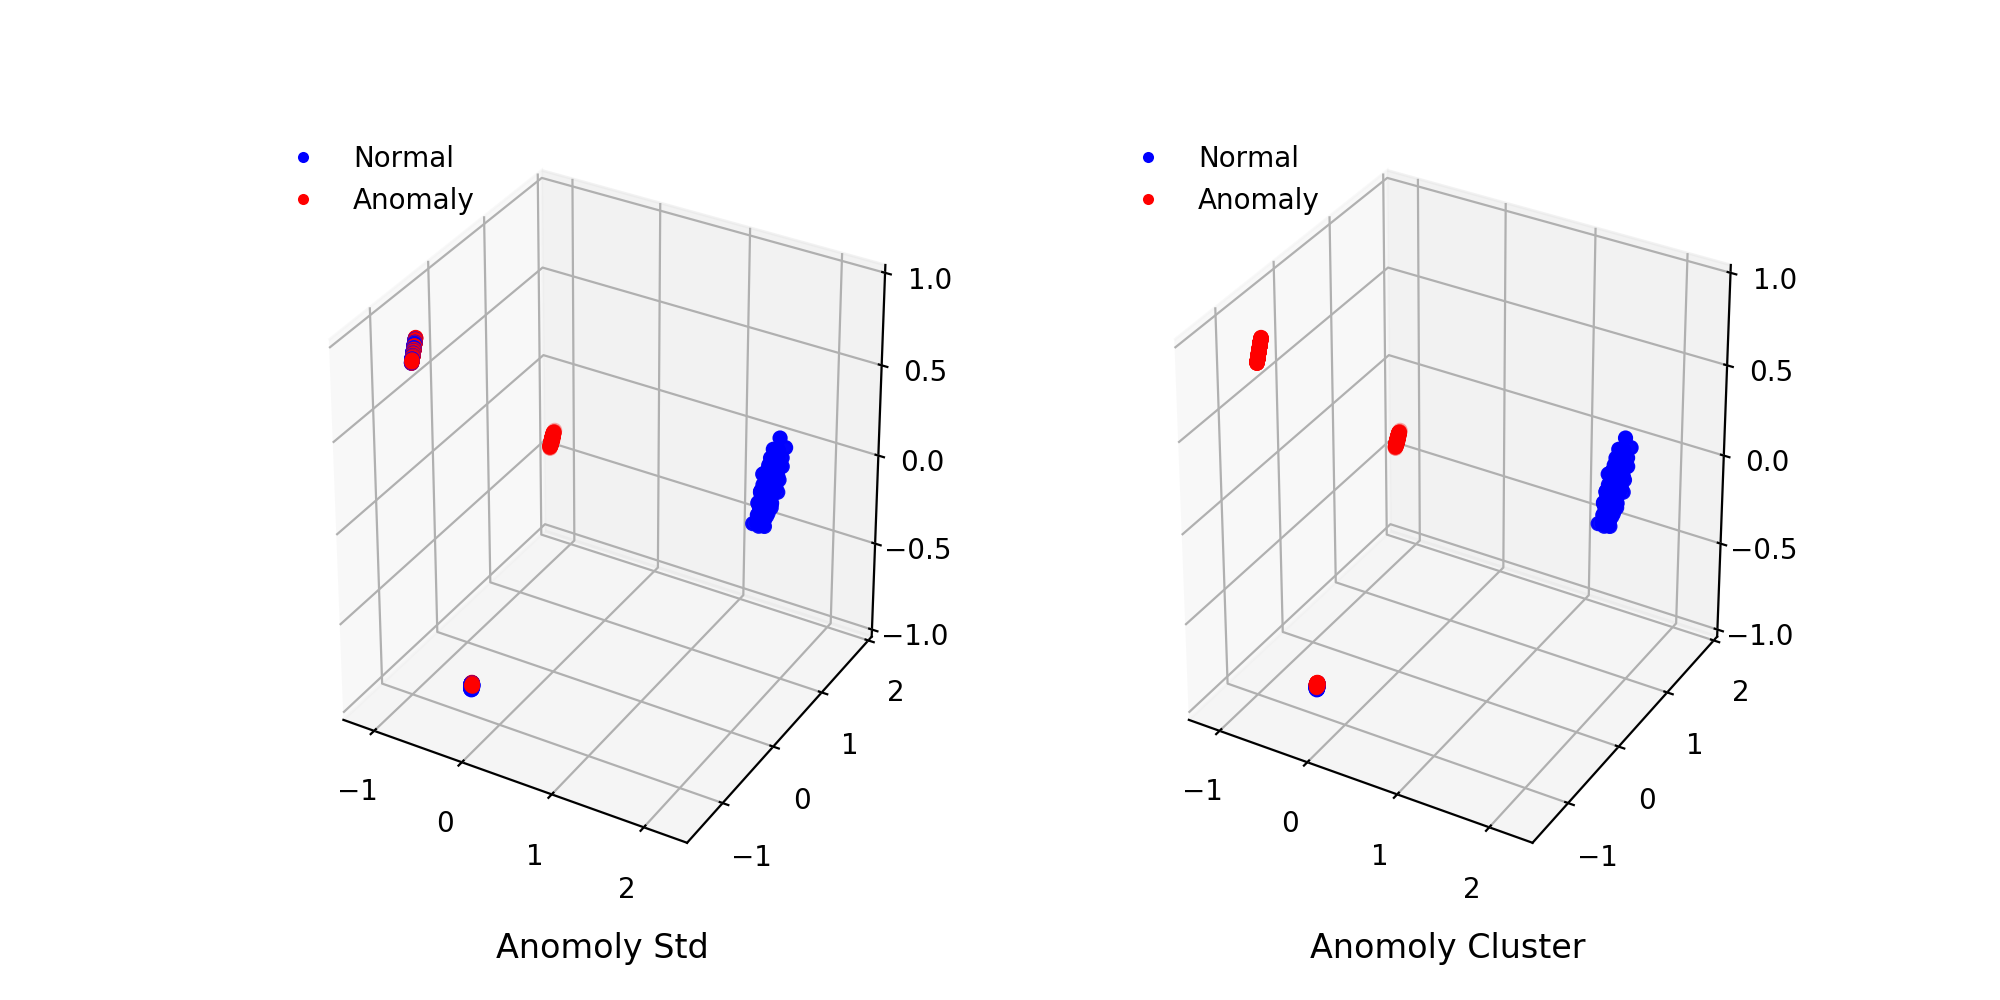

In [22]:
X_embedded1 = pd.DataFrame(gradual_anomalies_pca[1], columns=['X','Y', 'Z'])
X_embedded1['State'] = np.where(gradual_anomalies.anomaly_std, 'Failure', 'Normal')

X_embedded2 = pd.DataFrame(gradual_anomalies_pca[1], columns=['X','Y', 'Z'])
X_embedded2['State'] = np.where(gradual_anomalies.anomaly_cluster, 'Failure', 'Normal')


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title('Anomoly Std', y=-0.12)
ax2.set_title('Anomoly Cluster', y=-0.12)

colors_1 = ['red' if value == 'Failure' else 'blue' for value in X_embedded1.State.values]
ax1.scatter(X_embedded1.X.values, X_embedded1.Y.values, X_embedded1.Z.values, c=colors_1)

colors_2 = ['red' if value == 'Failure' else 'blue' for value in X_embedded2.State.values]
ax2.scatter(X_embedded2.X.values, X_embedded2.Y.values, X_embedded2.Z.values, c=colors_2)

#start, end = ax2.get_xlim()
#print(start, end)

ax1.xaxis.set_ticks([-1, 0, 1, 2])
ax1.yaxis.set_ticks([-1, 0, 1, 2])
ax1.zaxis.set_ticks([-1, -0.5, 0, 0.5, 1])

ax2.xaxis.set_ticks([-1, 0, 1, 2])
ax2.yaxis.set_ticks([-1, 0, 1, 2])
ax2.zaxis.set_ticks([-1, -0.5, 0, 0.5, 1])

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='b', markersize=5), 
                  Line2D([0], [0], marker='o', color='w', label='Anomaly', markerfacecolor='r', markersize=5)]

ax1.legend(handles=legend_elements, loc='upper left', frameon=False)
ax2.legend(handles=legend_elements, loc='upper left', frameon=False)

plt.show()